In [2]:
import numpy as np
import pandas as pd
from scipy import sparse
import pymorphy2
import sys
sys.path.insert(0, '/home/mlepekhin/Non-thematic-Text-Classification/code/allennlp_experiments')
from data_processing import *
from models import *
from interpretation import *

In [3]:
genre_list = ['A1', 'A4', 'A7', 'A8', 'A9', 'A11', 'A12', 'A13', 'A14', 'A16', 'A17', 'A20']

def get_df_from_file(filename):
    df = pd.DataFrame()
    
    with open(filename) as fin:
        for line in fin:
            best_genre = genre_list[np.argmax(list(map(float, line.split('\t')[1:13])))]
            if best_genre not in ['A13', 'A20']:
                df = df.append({'text': ' '.join(line.split('\t')[13].split()[1:]), 'target': best_genre}, ignore_index=True)
    return df

df_names = [1, 2, 3, 4, 5, 6, 7, 8]
df_list = []

for df_name in df_names:
    df_list.append(get_df_from_file(f'/home/mlepekhin/data/manual_genres/{df_name}.csv'))

In [4]:
MODELS_DIR = '/home/mlepekhin/models'

transformer_model1 = 'xlm-roberta-base'
MODEL_ID1 = 'allennlp_xlm_roberta_enru_attacked_15'
CHECKPOINTS_DIR1 = pathjoin(MODELS_DIR, MODEL_ID1, 'checkpoints')
BEST_MODEL1 = pathjoin(CHECKPOINTS_DIR1, 'best.th')

transformer_model2 = 'DeepPavlov/rubert-base-cased'
MODEL_ID2 = 'rubert_enru_attacked_15' 
CHECKPOINTS_DIR2 = pathjoin(MODELS_DIR, MODEL_ID2, 'checkpoints')
BEST_MODEL2 = pathjoin(CHECKPOINTS_DIR2, 'best.th')

MAX_TOKENS = 512

In [5]:
!gpustat

seven                Mon Mar 15 18:14:44 2021  440.64
[0] TITAN RTX        | 38'C,   0 % |  4769 / 24220 MB | sharuev(2791M) sharuev(1965M)
[1] TITAN RTX        | 86'C,  98 % |  8342 / 24220 MB | cwb(2651M) cwb(2679M) cwb(3001M)
[2] TITAN RTX        | 35'C,   0 % |    11 / 24220 MB |
[3] TITAN RTX        | 87'C,  99 % |  9928 / 24220 MB | cwb(3411M) cwb(3063M) cwb(3443M)


In [6]:
vocab1 = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID1, 'vocab'))
model1 = build_pool_transformer_model(vocab1, transformer_model1)
model1.load_state_dict(torch.load(BEST_MODEL1, map_location='cpu'))

03152021 18:14:44|INFO|allennlp.data.vocabulary| Loading token dictionary from /home/mlepekhin/models/allennlp_xlm_roberta_enru_attacked_15/vocab.
03152021 18:14:44|INFO|filelock| Lock 140458309483680 acquired on /home/mlepekhin/models/allennlp_xlm_roberta_enru_attacked_15/vocab/.lock
03152021 18:14:45|INFO|filelock| Lock 140458309483680 released on /home/mlepekhin/models/allennlp_xlm_roberta_enru_attacked_15/vocab/.lock


Building the model


03152021 18:14:45|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at /home/mlepekhin/.cache/torch/transformers/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
03152021 18:14:45|INFO|transformers.configuration_utils| Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 250002
}

03152021 18:14:45|INFO|transformers.modeling_util

<All keys matched successfully>

In [7]:
id_to_label1 = vocab1.get_index_to_token_vocabulary('labels')
label_to_id1 = vocab1.get_token_to_index_vocabulary('labels')
print(id_to_label1)
print(id_to_label1.values())

{0: 'A8', 1: 'A1', 2: 'A11', 3: 'A12', 4: 'A7', 5: 'A16', 6: 'A17', 7: 'A4', 8: 'A14', 9: 'A9', 10: 'A22'}
dict_values(['A8', 'A1', 'A11', 'A12', 'A7', 'A16', 'A17', 'A4', 'A14', 'A9', 'A22'])


In [8]:
vocab2 = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID2, 'vocab'))
model2 = build_transformer_model(vocab2, transformer_model2)
model2.load_state_dict(torch.load(BEST_MODEL2, map_location='cpu'))

03152021 18:15:02|INFO|allennlp.data.vocabulary| Loading token dictionary from /home/mlepekhin/models/rubert_enru_attacked_15/vocab.
03152021 18:15:02|INFO|filelock| Lock 140463920542912 acquired on /home/mlepekhin/models/rubert_enru_attacked_15/vocab/.lock
03152021 18:15:02|INFO|filelock| Lock 140463920542912 released on /home/mlepekhin/models/rubert_enru_attacked_15/vocab/.lock


Building the model


03152021 18:15:03|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/DeepPavlov/rubert-base-cased/config.json from cache at /home/mlepekhin/.cache/torch/transformers/b1ea51df212fa070e3a8a7d04dedb4800621e5a5bf504ecdb305faa622b46aa0.41d1cb30da8abef9028a44a17bd9c152daca0bd46e409bc271f324a28d109450
03152021 18:15:03|INFO|transformers.configuration_utils| Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "po

<All keys matched successfully>

In [9]:
id_to_label2 = vocab2.get_index_to_token_vocabulary('labels')
label_to_id2 = vocab2.get_token_to_index_vocabulary('labels')
print(id_to_label2)
print(id_to_label2.values())

{0: 'A8', 1: 'A1', 2: 'A11', 3: 'A12', 4: 'A7', 5: 'A16', 6: 'A17', 7: 'A4', 8: 'A14', 9: 'A9', 10: 'A22'}
dict_values(['A8', 'A1', 'A11', 'A12', 'A7', 'A16', 'A17', 'A4', 'A14', 'A9', 'A22'])


In [10]:
dataset_reader1 = build_transformer_dataset_reader(transformer_model1, MAX_TOKENS)
predictor1 = TextClassifierPredictor(model1, dataset_reader=dataset_reader1)

03152021 18:15:17|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at /home/mlepekhin/.cache/torch/transformers/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
03152021 18:15:17|INFO|transformers.configuration_utils| Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 250002
}

03152021 18:15:18|INFO|transformers.tokenization_

In [11]:
dataset_reader2 = build_transformer_dataset_reader(transformer_model2, MAX_TOKENS)
predictor2 = TextClassifierPredictor(model2, dataset_reader=dataset_reader2)

03152021 18:15:24|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/DeepPavlov/rubert-base-cased/config.json from cache at /home/mlepekhin/.cache/torch/transformers/b1ea51df212fa070e3a8a7d04dedb4800621e5a5bf504ecdb305faa622b46aa0.41d1cb30da8abef9028a44a17bd9c152daca0bd46e409bc271f324a28d109450
03152021 18:15:24|INFO|transformers.configuration_utils| Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "po

In [12]:
from tqdm import tqdm

'''
all_predicted_probs1 = []
all_predicted_labels1 = []

for df in tqdm(df_list):
    predicted_probs = [predictor1.predict(text)['probs'] for text in df.text.values]
    predicted_labels = [id_to_label1[np.argmax(probs)] for probs in predicted_probs]
    all_predicted_probs1.append(predicted_probs[:])
    all_predicted_labels1.append(predicted_labels[:])'''

"\nall_predicted_probs1 = []\nall_predicted_labels1 = []\n\nfor df in tqdm(df_list):\n    predicted_probs = [predictor1.predict(text)['probs'] for text in df.text.values]\n    predicted_labels = [id_to_label1[np.argmax(probs)] for probs in predicted_probs]\n    all_predicted_probs1.append(predicted_probs[:])\n    all_predicted_labels1.append(predicted_labels[:])"

In [13]:
import pickle
#pickle.dump(all_predicted_probs1, open('xlm_roberta_probs_15_3.pkl', 'wb'))
all_predicted_probs1 = pickle.load(open('xlm_roberta_probs_15_3.pkl', 'rb'))

In [14]:
'''all_predicted_probs2 = []
all_predicted_labels2 = []

for df in tqdm(df_list):
    predicted_probs = [predictor2.predict(text)['probs'] for text in df.text.values]
    predicted_labels = [id_to_label2[np.argmax(probs)] for probs in predicted_probs]
    all_predicted_probs2.append(predicted_probs[:])
    all_predicted_labels2.append(predicted_labels[:])'''

"all_predicted_probs2 = []\nall_predicted_labels2 = []\n\nfor df in tqdm(df_list):\n    predicted_probs = [predictor2.predict(text)['probs'] for text in df.text.values]\n    predicted_labels = [id_to_label2[np.argmax(probs)] for probs in predicted_probs]\n    all_predicted_probs2.append(predicted_probs[:])\n    all_predicted_labels2.append(predicted_labels[:])"

In [15]:
#pickle.dump(all_predicted_probs2, open('rubert_probs.pkl', 'wb'))
all_predicted_probs2 = pickle.load(open('rubert_probs.pkl', 'rb'))

In [16]:
from sklearn.metrics import accuracy_score

all_targets = np.concatenate([df.target.values for df in df_list])
all_texts = np.concatenate([df.text.values for df in df_list])
all_names = np.concatenate([[df_name] * len(df) for df, df_name in zip(df_list, df_names)])

#all_predictions1 = np.concatenate(all_predicted_labels1)
total_probs1 = np.concatenate(all_predicted_probs1)

#all_predictions2 = np.concatenate(all_predicted_labels2)
total_probs2 = np.concatenate(all_predicted_probs2)

In [17]:
unique_labels = sorted(np.unique(pd.read_csv('/home/mlepekhin/data/en_train').target.values))

In [18]:
from classic_models import *

In [19]:
new_lr, new_vectorizer = load_model('lr_enru_noattacked')

In [20]:
id_to_label3 = {label_id: label for label_id, label in enumerate(new_lr.classes_)}
label_to_id3 = {label: label_id for label_id, label in enumerate(new_lr.classes_)}

In [21]:
all_predicted_probs3 = []
all_predicted_labels3 = []

for df in tqdm(df_list):
    predicted_probs = new_lr.predict_proba(new_vectorizer.transform(df.text.values))
    predicted_labels = [id_to_label3[np.argmax(probs)] for probs in predicted_probs]
    all_predicted_probs3.append(predicted_probs[:])
    all_predicted_labels3.append(predicted_labels[:])

100%|██████████| 8/8 [00:15<00:00,  1.90s/it]


In [22]:
total_probs3 = np.concatenate(all_predicted_probs3)

In [23]:
total_probs4 = np.load('../../../../textattack_experiments/ru_lstm_attention/livejournal_probs.npy')

In [24]:
def test_ensemble(alpha_xlm_roberta, alpha_rubert, alpha_lr, show_detailed_statistics=False):
    alpha_lstm = 1 - alpha_xlm_roberta - alpha_rubert
    normalized_probs1 = np.zeros_like(total_probs1).astype(float)
    normalized_probs2 = np.zeros_like(total_probs2).astype(float)
    normalized_probs3 = np.zeros_like(total_probs3).astype(float)
    normalized_probs4 = np.zeros_like(total_probs4).astype(float)
    
    for label_id, label in enumerate(unique_labels):
        normalized_probs1[:, label_id] = total_probs1[:, label_to_id1[label]]
        normalized_probs2[:, label_id] = total_probs2[:, label_to_id2[label]]
        normalized_probs3[:, label_id] = total_probs3[:, label_to_id3[label]]
    normalized_probs4 = total_probs4
        
    ensemble_probs = alpha_xlm_roberta * normalized_probs1
    ensemble_probs += alpha_rubert * normalized_probs2
    ensemble_probs += alpha_lr * normalized_probs3
    ensemble_probs += alpha_lstm * normalized_probs4
    
    
    ensemble_predictions = [unique_labels[label_id] for label_id in np.argmax(ensemble_probs, axis=1)]
    #print(ensemble_predictions)
    #print(all_targets)
    total_accuracy = accuracy_score(ensemble_predictions, all_targets)
    #print('overall accuracy', total_accuracy)
    
    if show_detailed_statistics:
        calc_classifier_metrics(np.array(ensemble_predictions), all_targets)
        plot_confusion_matrix(np.array(ensemble_predictions), all_targets)
        plt.show()
    
    return total_accuracy

/home/mlepekhin/Non-thematic-Text-Classification/code/allennlp_experiments/interpretation.py:90: RuntimeWarning: invalid value encountered in true_divide
  normed_cm = (cm.T / sums).T
03152021 18:15:56|INFO|numexpr.utils| Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
03152021 18:15:56|INFO|numexpr.utils| NumExpr defaulting to 8 threads.


label (argum) f1_score 0.5520361990950226 precision 0.6054590570719603 recall 0.5072765072765073
label (fictive) f1_score 0.6771653543307087 precision 0.7087912087912088 recall 0.6482412060301508
label (instruct) f1_score 0.7297297297297297 precision 0.7584269662921348 recall 0.703125
label (reporting) f1_score 0.935579781962339 precision 0.9383697813121272 recall 0.932806324110672
label (legal) f1_score 0.6153846153846153 precision 0.48 recall 0.8571428571428571
label (personal) f1_score 0.72236727589208 precision 0.6525157232704403 recall 0.8089668615984406
label (commercial) f1_score 0.40522875816993464 precision 0.36470588235294116 recall 0.45588235294117646
label (research) f1_score 0.47619047619047616 precision 0.45454545454545453 recall 0.5
label (info) f1_score 0.5802469135802469 precision 0.6143790849673203 recall 0.5497076023391813
label (eval) f1_score 0.5371428571428571 precision 0.5696969696969697 recall 0.5081081081081081
accuracy 0.7641429777652687


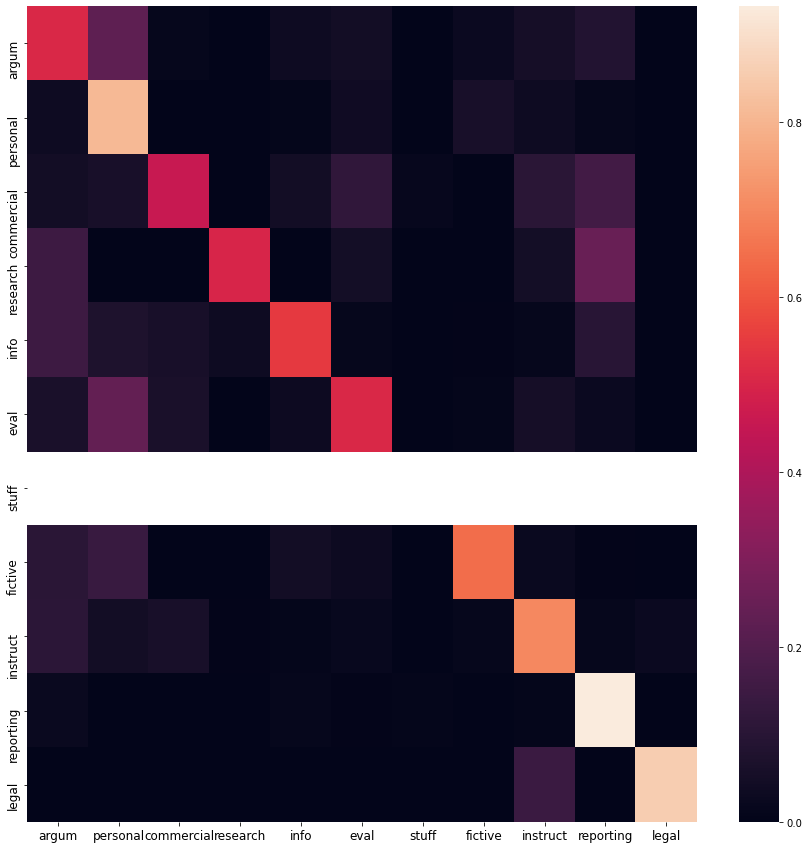

0.7641429777652687

In [25]:
test_ensemble(0.8, 0, 0.2, show_detailed_statistics=True)

label (argum) f1_score 0.5498281786941581 precision 0.6122448979591837 recall 0.498960498960499
label (fictive) f1_score 0.6770025839793281 precision 0.6968085106382979 recall 0.6582914572864321
label (instruct) f1_score 0.738255033557047 precision 0.7617728531855956 recall 0.7161458333333334
label (reporting) f1_score 0.9373549883990719 precision 0.9432955303535691 recall 0.9314888010540184
label (legal) f1_score 0.6153846153846153 precision 0.48 recall 0.8571428571428571
label (personal) f1_score 0.7232924693520141 precision 0.6565977742448331 recall 0.8050682261208577
label (commercial) f1_score 0.4078947368421053 precision 0.36904761904761907 recall 0.45588235294117646
label (research) f1_score 0.48888888888888893 precision 0.44 recall 0.55
label (info) f1_score 0.5783132530120482 precision 0.5962732919254659 recall 0.5614035087719298
label (eval) f1_score 0.5352112676056339 precision 0.5588235294117647 recall 0.5135135135135135
accuracy 0.7649873346467774


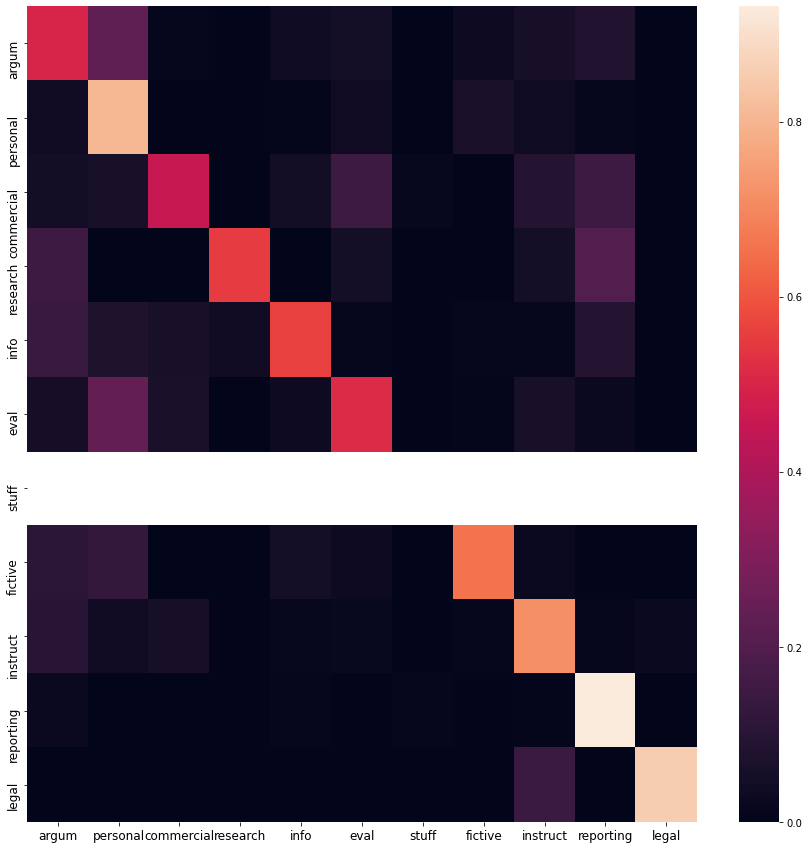

0.7649873346467774

In [26]:
test_ensemble(1, 0, 0, show_detailed_statistics=True)

label (argum) f1_score 0.577433628318584 precision 0.6170212765957447 recall 0.5426195426195426
label (fictive) f1_score 0.6755319148936171 precision 0.7175141242937854 recall 0.6381909547738693
label (instruct) f1_score 0.7196652719665272 precision 0.7747747747747747 recall 0.671875
label (reporting) f1_score 0.9487852921864741 precision 0.9456806282722513 recall 0.9519104084321476
label (legal) f1_score 0.6 precision 0.46153846153846156 recall 0.8571428571428571
label (personal) f1_score 0.7328646748681897 precision 0.6672 recall 0.8128654970760234
label (commercial) f1_score 0.38743455497382195 precision 0.3008130081300813 recall 0.5441176470588235
label (research) f1_score 0.4390243902439024 precision 0.42857142857142855 recall 0.45
label (info) f1_score 0.5841269841269842 precision 0.6388888888888888 recall 0.5380116959064327
label (eval) f1_score 0.5207100591715976 precision 0.5751633986928104 recall 0.4756756756756757
accuracy 0.7728679988741908


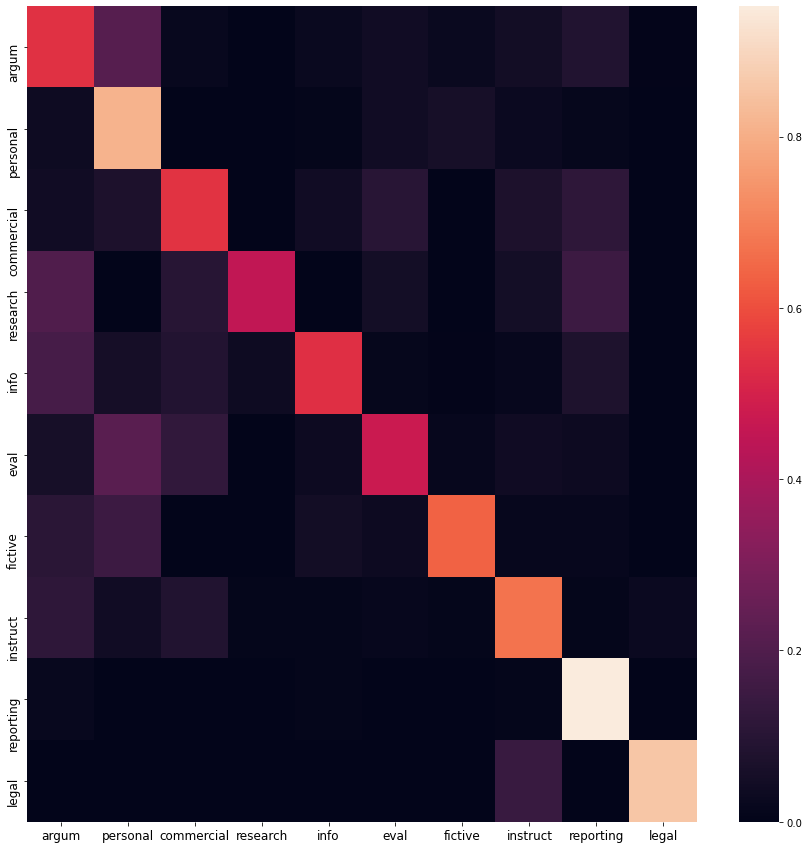

0.7728679988741908

In [27]:
test_ensemble(0.62, 0.38, 0, show_detailed_statistics=True)

In [28]:
best_coeff = (0, 0)
best_accuracy = 0

for i in np.linspace(0, 1, 100):
    for j in np.linspace(0, 1-i, 100):
        cur_acc = test_ensemble(i, j, 1 - i - j)
        if cur_acc > best_accuracy:
            best_accuracy = cur_acc
            best_coeff = (i, j, 1 - i - j)

(0.6363636363636365, 0.35629017447199257, 0.007346189164370964)
label (argum) f1_score 0.5784204671857619 precision 0.6220095693779905 recall 0.5405405405405406
label (fictive) f1_score 0.6861702127659575 precision 0.7288135593220338 recall 0.6482412060301508
label (instruct) f1_score 0.7176634214186369 precision 0.7701492537313432 recall 0.671875
label (reporting) f1_score 0.947195801902263 precision 0.9431743958197256 recall 0.9512516469038208
label (legal) f1_score 0.6 precision 0.46153846153846156 recall 0.8571428571428571
label (personal) f1_score 0.7326906222611743 precision 0.6656050955414012 recall 0.8148148148148148
label (commercial) f1_score 0.391304347826087 precision 0.3103448275862069 recall 0.5294117647058824
label (research) f1_score 0.4390243902439024 precision 0.42857142857142855 recall 0.45
label (info) f1_score 0.5841269841269842 precision 0.6388888888888888 recall 0.5380116959064327
label (eval) f1_score 0.5263157894736842 precision 0.5732484076433121 recall 0.4864

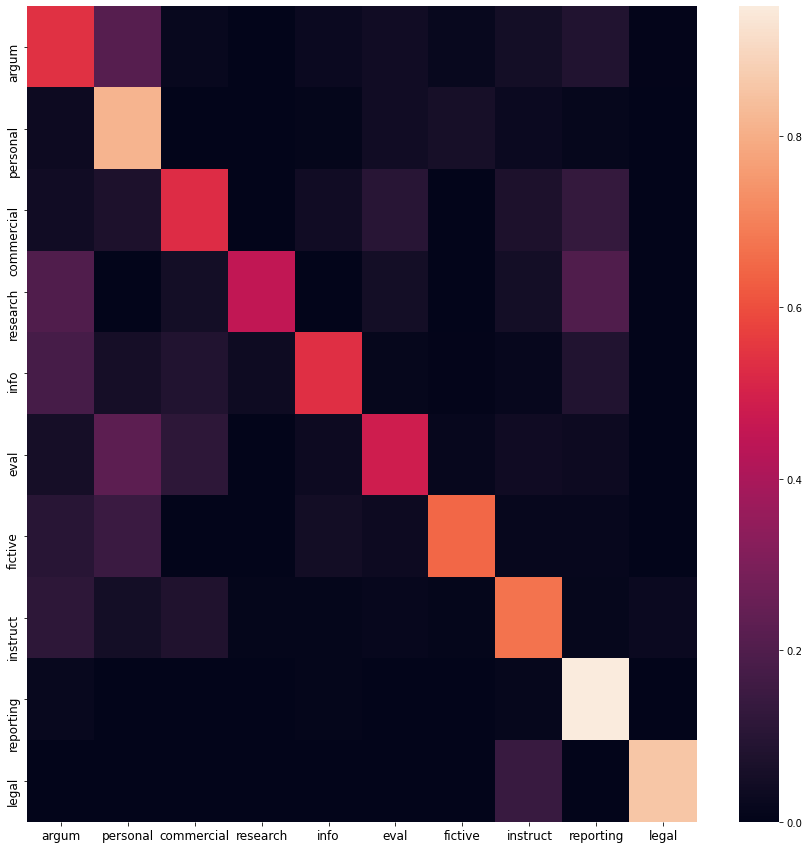

0.7734309034618632

In [29]:
print(best_coeff)
test_ensemble(*best_coeff, show_detailed_statistics=True)

In [30]:
best_coeff = (0, 0)
best_accuracy = 0

for i in tqdm(np.linspace(0, 1, 20)):
    for j in np.linspace(0, 1-i, 20):
        for l in np.linspace(0, 1-i-j, 20):
            cur_acc = test_ensemble(i, j, l)
            if cur_acc > best_accuracy:
                best_accuracy = cur_acc
                best_coeff = (i, j, l)
print(best_coeff)
print(best_accuracy)

100%|██████████| 20/20 [00:28<00:00,  1.42s/it]

(0.631578947368421, 0.3490304709141275, 0.0020411138649948954)
0.773149451168027


(0.631578947368421, 0.3490304709141275, 0.0020411138649948954)
label (argum) f1_score 0.5777777777777778 precision 0.6205250596658711 recall 0.5405405405405406
label (fictive) f1_score 0.6861702127659575 precision 0.7288135593220338 recall 0.6482412060301508
label (instruct) f1_score 0.7186629526462395 precision 0.7724550898203593 recall 0.671875
label (reporting) f1_score 0.947195801902263 precision 0.9431743958197256 recall 0.9512516469038208
label (legal) f1_score 0.6 precision 0.46153846153846156 recall 0.8571428571428571
label (personal) f1_score 0.7309377738825591 precision 0.6640127388535032 recall 0.8128654970760234
label (commercial) f1_score 0.391304347826087 precision 0.3103448275862069 recall 0.5294117647058824
label (research) f1_score 0.4390243902439024 precision 0.42857142857142855 recall 0.45
label (info) f1_score 0.5841269841269842 precision 0.6388888888888888 recall 0.5380116959064327
label (eval) f1_score 0.5263157894736842 precision 0.5732484076433121 recall 0.48648

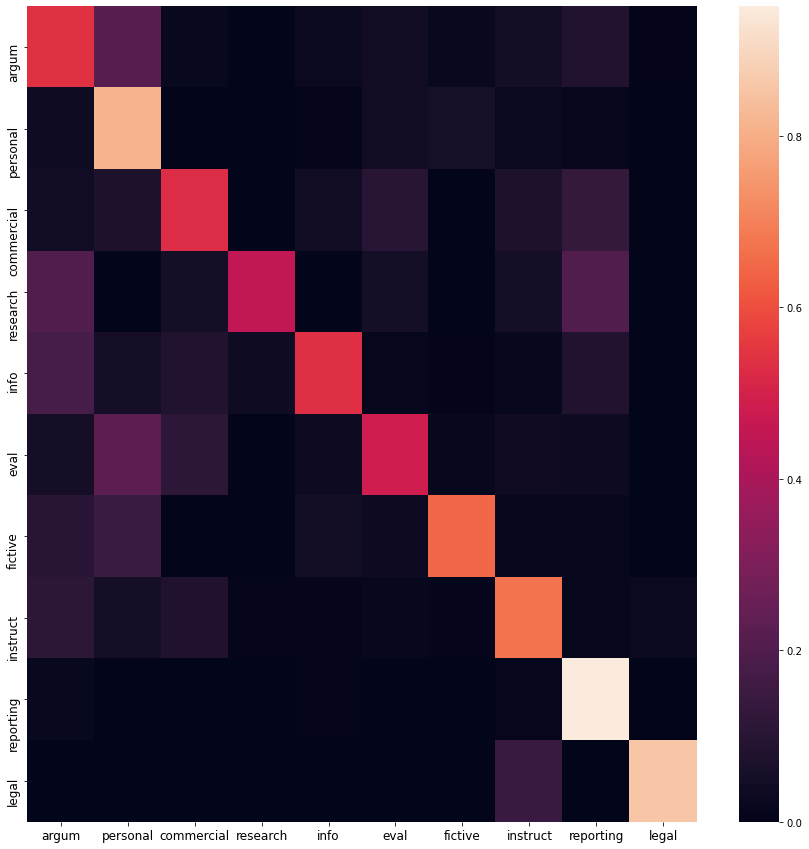

0.773149451168027

In [31]:
print(best_coeff)
test_ensemble(*best_coeff, show_detailed_statistics=True)